# Reading the data 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('./dataset/training_set_VU_DM.csv')
df_test = pd.read_csv('./dataset/test_set_VU_DM.csv')

# General information

In [2]:
print(df.shape)
print(df_test.shape)

print(df.dtypes)

(4958347, 54)
(4959183, 50)
srch_id                          int64
date_time                       object
site_id                          int64
visitor_location_country_id      int64
visitor_hist_starrating        float64
visitor_hist_adr_usd           float64
prop_country_id                  int64
prop_id                          int64
prop_starrating                  int64
prop_review_score              float64
prop_brand_bool                  int64
prop_location_score1           float64
prop_location_score2           float64
prop_log_historical_price      float64
position                         int64
price_usd                      float64
promotion_flag                   int64
srch_destination_id              int64
srch_length_of_stay              int64
srch_booking_window              int64
srch_adults_count                int64
srch_children_count              int64
srch_room_count                  int64
srch_saturday_night_bool         int64
srch_query_affinity_score      float

~5 millions rows, 54 attributes for the train set
Other than date_time, all the columns are int/float

# Null values

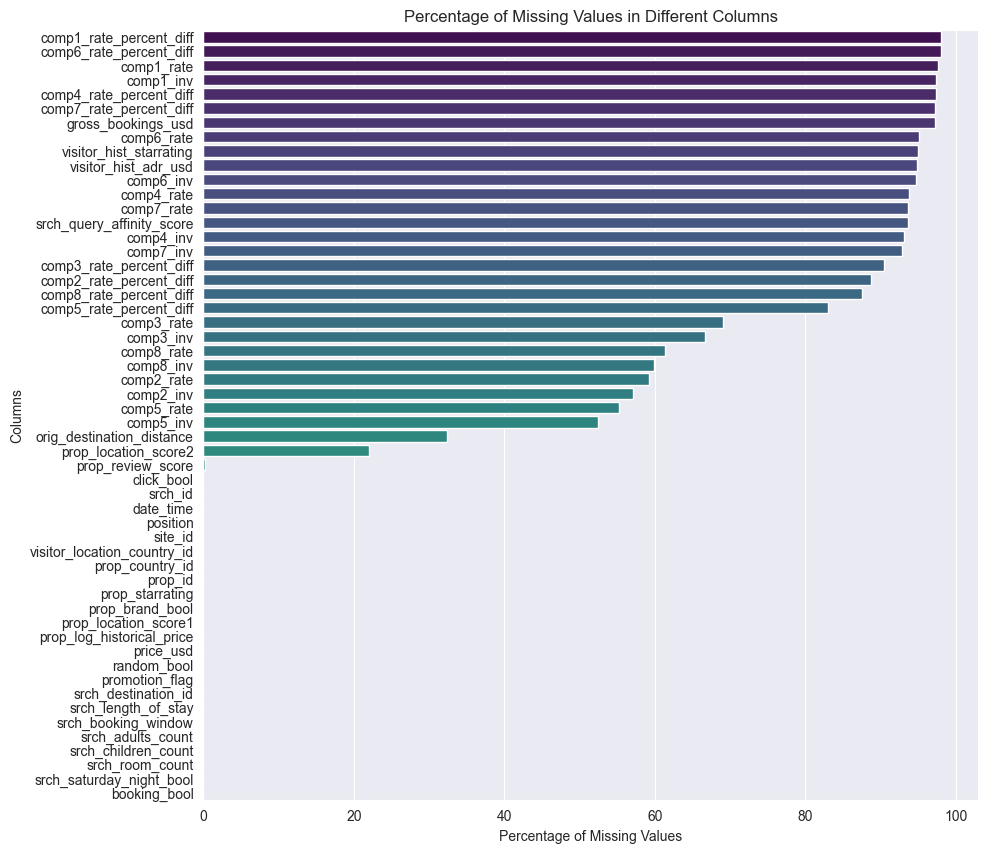

In [3]:
missing_percentage = (df.isnull().mean() * 100).round(2)

# Sort columns by missing percentage
missing_percentage = missing_percentage.sort_values(ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 10))
sns.barplot(x=missing_percentage.values, y=missing_percentage.index, palette='viridis')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Columns')
plt.title('Percentage of Missing Values in Different Columns')
plt.show()

A good chunk of the data for certain columns seems to be missing, have to decide whether to drop or impute!

# Target label 
the goal of the dataset is to rank search results for the most likely properties to be clicked and subsequently booked, one possible target label can be the aggregation of the click_bool and booking_bool columns based on the relevance criteria 

In [4]:
df['target_label'] = 0

# 5 - The user purchased a room at this hotel
# 1 - The user clicked through to see more information on this hotel
# 0 - The user neither clicked on this hotel nor purchased a room at this hotel
df.loc[df['click_bool'] == 1, 'target_label'] = 1
df.loc[df['booking_bool'] == 1, 'target_label'] = 5

# Looking more in depth at some of the features
## visitor_location_country_id

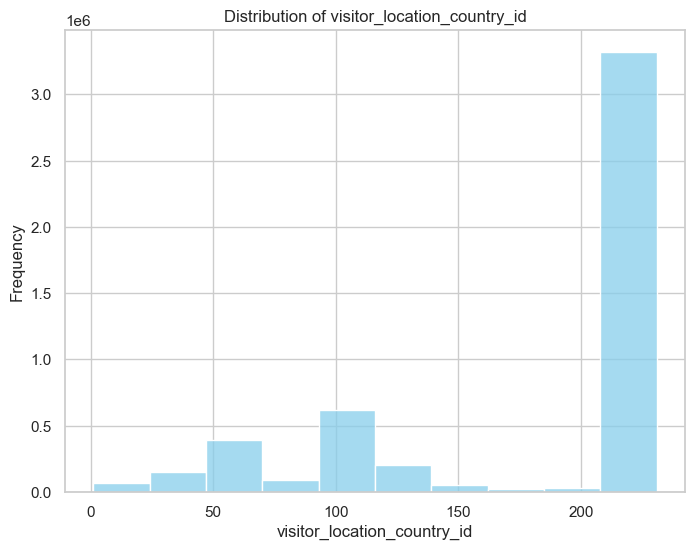

In [5]:
sns.set(style="whitegrid")

# Plot distribution of the selected attribute
plt.figure(figsize=(8, 6))
sns.histplot(data=df['visitor_location_country_id'], kde=False, color='skyblue', bins=10)
plt.title('Distribution of visitor_location_country_id')
plt.xlabel('visitor_location_country_id')
plt.ylabel('Frequency')
plt.show()

In [6]:
df['visitor_location_country_id'].value_counts()

visitor_location_country_id
219    2892489
100     495476
55      290461
216     217385
220     174296
        ...   
226         25
190         24
146         15
83          13
150          8
Name: count, Length: 210, dtype: int64

In [7]:
df['prop_country_id'].value_counts()

prop_country_id
219    3030125
100     311283
55      186465
31      154287
99      135388
        ...   
180         12
7           10
126          7
204          5
165          2
Name: count, Length: 172, dtype: int64

Seems like the majority of the users and hotels are from the country with id 219, most likely the US since expedia is an american company

# Users rating and purchase history
~90% of the users in the training set do not have a have a purchase/rating history

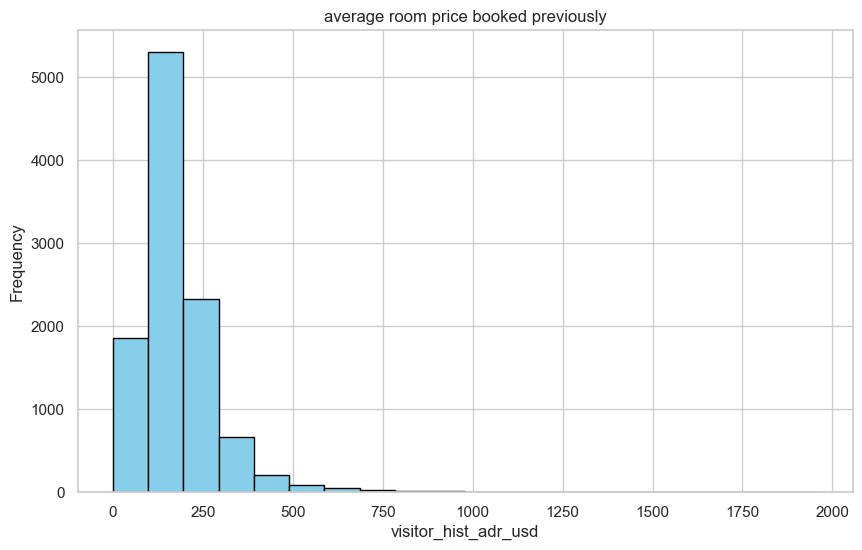

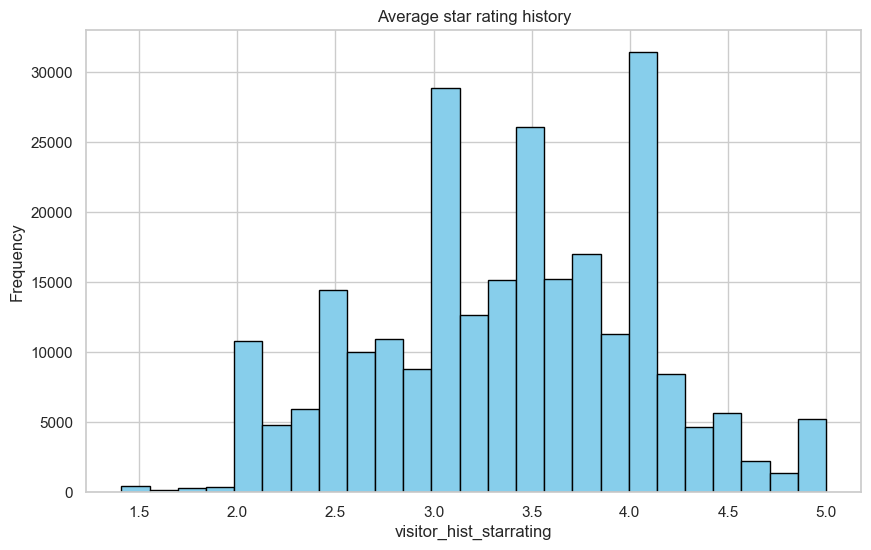

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(df.groupby('srch_id').first()['visitor_hist_adr_usd'], bins=20, color='skyblue', edgecolor='black')
plt.title('average room price booked previously')
plt.xlabel('visitor_hist_adr_usd')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(df['visitor_hist_starrating'], bins=25, color='skyblue', edgecolor='black')
plt.title('Average star rating history')
plt.xlabel('visitor_hist_starrating')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Features to detect similar users for CF
looking at the data, an initial set of features to detect similar users can be: search parameters + individual user data
for example: 
Search parameters: 'srch_destination_id', 'srch_length_of_stay', 'srch_adults_count', 'srch_children_count', 'srch_room_count', srch_saturday_night_bool' which all are fully available in the dataset
User attributes: 'visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd'

perhaps using cosine similarity, or some weighted approach... need to find one that captures the similarity the best



In [9]:
from IPython.display import Image
# src: https://towardsdatascience.com/machine-learning-model-for-predicting-click-through-in-hotel-online-ranking-d55fc18c8516
Image(url="https://miro.medium.com/v2/resize:fit:4800/format:webp/1*feRBOEwTPGtg2OURVqVZuw.png", height=300) 

In [10]:
user_similarity_features = ['srch_id', 'srch_destination_id', 'srch_length_of_stay', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd']
users = df[user_similarity_features].groupby(by='srch_id').first()
users

,srch_destination_id,srch_length_of_stay,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd
srch_id,,,,,,,,,
1,23246,1,4,0,1,1,187,NaN,NaN
4,12588,2,1,0,1,1,219,NaN,NaN
6,21106,1,2,0,1,0,100,NaN,NaN
8,7082,1,1,0,1,0,219,NaN,NaN
11,12610,1,2,0,1,1,219,NaN,NaN
...,...,...,...,...,...,...,...,...,...
332777,4138,5,2,1,1,0,31,NaN,NaN
332781,25455,2,1,0,1,1,219,NaN,NaN
332782,1470,2,1,0,1,1,158,NaN,NaN


In [11]:
import numpy as np

def cosine_similarity_matrix_non_null(data):
    num_vectors, num_features = data.shape
    similarity_matrix = np.zeros((num_vectors, num_vectors))
    
    for i in range(num_vectors):
        for j in range(num_vectors):
            # Find indices where both vectors have non-null values
            non_null_indices = data.iloc[[i, j]].notnull().all(axis=0)
            
            # Filter vectors to only include non-null values
            vector1_non_null = data.iloc[i][non_null_indices]
            vector2_non_null = data.iloc[j][non_null_indices]
            
            # Calculate cosine similarity for non-null values
            dot_product = np.dot(vector1_non_null, vector2_non_null)
            norm_vector1 = np.linalg.norm(vector1_non_null)
            norm_vector2 = np.linalg.norm(vector2_non_null)
            
            # Handle case where no non-null values exist
            if norm_vector1 == 0 or norm_vector2 == 0:
                similarity_matrix[i][j] = 0  # Cosine similarity is 0 when one or both vectors are all zeros
            else:
                similarity_matrix[i][j] = dot_product / (norm_vector1 * norm_vector2)
    
    return similarity_matrix

similarity_matrix = cosine_similarity_matrix_non_null(users.head())
print("Cosine Similarity Matrix (only for non-null entries):")
print(similarity_matrix)
users.head()

Cosine Similarity Matrix (only for non-null entries):
[[1.         0.99995626 0.99999453 0.9997385  0.99995656]
 [0.99995626 1.         0.99991988 0.99990863 0.99999999]
 [0.99999453 0.99991988 1.         0.99965743 0.99992027]
 [0.9997385  0.99990863 0.99965743 1.         0.99990822]
 [0.99995656 0.99999999 0.99992027 0.99990822 1.        ]]


,srch_destination_id,srch_length_of_stay,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd
srch_id,,,,,,,,,
1,23246,1,4,0,1,1,187,NaN,NaN
4,12588,2,1,0,1,1,219,NaN,NaN
6,21106,1,2,0,1,0,100,NaN,NaN
8,7082,1,1,0,1,0,219,NaN,NaN
11,12610,1,2,0,1,1,219,NaN,NaN


Eh, doesn't look that promising

# Dropping columns 
For starters, we can drop columns that do not provide valuable information or are missing a lot of values

- Dropping the different company attribute since the majority of the values are missing, and they seem to provide little information (the only thing that comes to mind perhaps is if someone visits expedia, therefore, they trust the brand more, and thus seeing them having more expensive options would not change their mind... WAY too hard to capture... perhaps better to drop for now)
- date_time: since no one cares about when search took place (might matter in some cases like trends and seasonality but will be also extremely hard to do)
- gross_booking: since  our model should not care about how much they spent on the hotel, and only if they purchase or not
- click_bool, booking_book: transformed into a relevant target_bool column
- srch_affinity_score: I do not understand this attribute or how it's supposed to be relevant. Will remove now, revisit late 
- srch_booking_window: Irrelevant for ranking
- prop_location_score2: missing 22%, seems very valuable, find suitable imputation method
- 'orig_destination_distance', 'srch_query_affinity_score': LOTS of missing values, Might impute later to test
- random_bool: an interesting attribute but fail to see its relevance, will revisit!

In [12]:
drop_columns_train = ['date_time', 'site_id', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff', 'click_bool', 'booking_bool', 'gross_bookings_usd',
        'srch_booking_window', 'prop_location_score2', 'orig_destination_distance', 'srch_query_affinity_score', 'random_bool']

drop_columns_test = ['date_time', 'site_id', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff',
        'srch_booking_window', 'prop_location_score2', 'orig_destination_distance', 'srch_query_affinity_score', 'random_bool']

df.drop(columns=drop_columns_train, inplace=True)
df_test.drop(columns=drop_columns_test, inplace=True)

# Plot dump 

# Experimenting with imputation

User history rating, THE majority is null. Use mean imputation to fill these values. The idea is that the majority of the people will not rate too high or too low. 
Another approache besides mean imputation is to learn the distribution of the data (for example normal distribution for the average rating) and impute based on that, so it would retain it's normal distribution.... 

In [13]:
for column in ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_review_score']:
    mean_value = df[column].mean()
    df[column].fillna(mean_value, inplace=True)

for column in ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_review_score']:
    mean_value = df_test[column].mean()
    df_test[column].fillna(mean_value, inplace=True)




# Normalizing the target_label
might not be needed since apparently xgboost method relies on decision trees and normalization is not required for that

In [14]:
df.to_csv("./dataset/train_clean_v1.csv", index=False)
df_test.to_csv("./dataset/test_clean_v1.csv", index=False)


# Removing the unique identifiers

In [15]:
unique_ids = ['visitor_location_country_id', 'srch_destination_id']

df.drop(columns=unique_ids, inplace=True)
df_test.drop(columns=unique_ids, inplace=True)

df.to_csv("./dataset/train_clean_v1_noIDs.csv", index=False)
df_test.to_csv("./dataset/test_clean_v1_noIDs.csv", index=False)

# Some potential TODOs

In [16]:
# TODO: HEAAVILY imbalanced target label
# TODO: investigate if possible to combine learning to rank model with collaborative filtering/content-based 